In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [9]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [11]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.
 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 586466
Experiment type: el

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\burst_analyses'

## Test one subject

### Get stim-evoked spikes and analyze

In [15]:
## Parameters ##
apply_car = True
celltype = None # 'RS', 'FS', or None (chooses all cells)
time_bin = 0.005 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [16]:
group = 'MOs_deep'
mouse_num = '569069' # could also try 569069, 569062

stim_area = group[:2]
stim_depth = group.split('_')[-1]
mdata = multi_sub_dict[group][mouse_num]
evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')

## Load unit info ##
fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))
#     continue

## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
try:
    bad_chs = mdata['bad_chs']
except KeyError:
    badchstr = exp_meta['EEG bad_channels'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
        
## Load stim log (includes running speed now) ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
event_window = all_unit_event_spikes['event_window']
# bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
# timex = bins[:-1] + time_bin/2

## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
mdata['good_chs'] = GOOD_CHS

## Get event inds ##
all_event_inds = {}
for leveli, parami in zip(current_levels, currents_list):
    all_event_inds[leveli] = {}
    for statei in test_states:
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][substatei] = np.concatenate(state_events)
        else:
            state_events = []
            for sweepi in sweeps:
                events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                if len(events) == 0:
                    continue
                state_events.append(events)
            all_event_inds[leveli][statei] = np.concatenate(state_events)

## Get evoked EEG traces ##
EEG_traces = {}
for leveli, states_event_times in all_event_inds.items():
    EEG_traces[leveli] = {}
    for statei, event_inds in states_event_times.items():
        event_traces = all_EEG_traces[:, :, event_inds]
        ## Apply common avg ##
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]

## Population units ##
reg_unit_info = {}
for region in areas_of_interest.keys():
    if celltype:
        regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
    else:
        regdf = unit_info[unit_info['parent'] == region]
    if len(regdf) > 8:
        reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)

start = time.time()
## Loop through regions/units to get event-related spike times ##
pop_event_spikes = {}
unit_event_spikes = {}
unit_event_bursts = {}
for leveli, states_event_times in all_event_inds.items():
    pop_event_spikes[leveli] = {}
    unit_event_spikes[leveli] = {}
    unit_event_bursts[leveli] = {}
    for statei, event_inds in states_event_times.items():
        pop_event_spikes[leveli][statei] = {}
        unit_event_spikes[leveli][statei] = {}
        unit_event_bursts[leveli][statei] = {}
        for regi, regdf in reg_unit_info.items():
            ## Get population event spike times ##
            pop_raster = []
            for eventi in event_inds:
                event_spikes = []
                for ii, unitrow in regdf.iterrows():
                    event_spikes.append(all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi])
                pop_raster.append(np.sort(np.concatenate(event_spikes)))
            pop_event_spikes[leveli][statei][regi] = pop_raster
            
            ## Get unit event spike times ##
            for ii, unitrow in regdf.iterrows():
                unit_event_spikes[leveli][statei][unitrow.unit_id] = \
                    [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                unit_event_bursts[leveli][statei][unitrow.unit_id] = {
                    'times': [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds],
                    'counts': [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['counts'][ei] for ei in event_inds]
                }

del all_unit_event_spikes, all_EEG_traces, EEG_event_timestamps
end = time.time()
print('Time to get event spike times: {:.2f} s'.format(end-start))

Time to get event spike times: 26.19 s


In [17]:
GOOD_CHS

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

## Does EEG 2nd peak magnitude correlate with population firing rate on a trial-by-trial basis?

Apply correlation test to all electrodes

In [18]:
pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'
test_window = [0.15, 0.3]
time_bin = 0.005

einds = all_event_inds[pstim][pstate]
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1]
eeginds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
bleeginds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

bins = np.arange(-2.0, 2.0 + time_bin, time_bin)
timex = bins[:-1] + time_bin / 2
frinds = np.nonzero((timex >= test_window[0]) & (timex <= test_window[1]))[0]
blfrinds = np.nonzero((timex >= -test_window[1]) & (timex <= -test_window[0]))[0]

EEGauc = np.zeros((eegtraces.shape[1], len(einds)), dtype=float)
blEEGauc = np.zeros((eegtraces.shape[1], len(einds)), dtype=float)
popFRs = np.zeros((len(timex), len(einds)), dtype=float) * np.nan
FRauc = np.zeros(len(einds), dtype=float)
blFRauc = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    blEEGauc[:, jj] = integrate.simps(np.abs(eegtraces[bleeginds, :, jj]), eegtime[bleeginds], axis=0, even='last')
    EEGauc[:, jj] = integrate.simps(np.abs(eegtraces[eeginds, :, jj]), eegtime[eeginds], axis=0, even='last')
    
    ## Get popFR magnitude ##
    spcounts, edges = np.histogram(pop_event_spikes[pstim][pstate][regi][jj], bins)
    popFRs[:, jj] = spcounts / time_bin
    blFRauc[jj] = integrate.simps(popFRs[blfrinds, jj], timex[blfrinds], axis=0, even='last')
    FRauc[jj] = integrate.simps(popFRs[frinds, jj], timex[frinds], axis=0, even='last')
    
EEGmag = (EEGauc - np.mean(blEEGauc, axis=0)) / np.std(blEEGauc, axis=0)
FRmag = (FRauc - np.mean(blFRauc)) / np.std(blFRauc)
    
Prs, Pps = np.zeros((eegtraces.shape[1]), dtype=float), np.zeros((eegtraces.shape[1]), dtype=float)
Sprs, Spps = np.zeros((eegtraces.shape[1]), dtype=float), np.zeros((eegtraces.shape[1]), dtype=float)
for ii in range(eegtraces.shape[1]):
    Prs[ii], Pps[ii] = stats.pearsonr(FRmag, EEGmag[ii,:])
    Sprs[ii], Spps[ii] = stats.spearmanr(FRmag, EEGmag[ii,:])

<IPython.core.display.Javascript object>


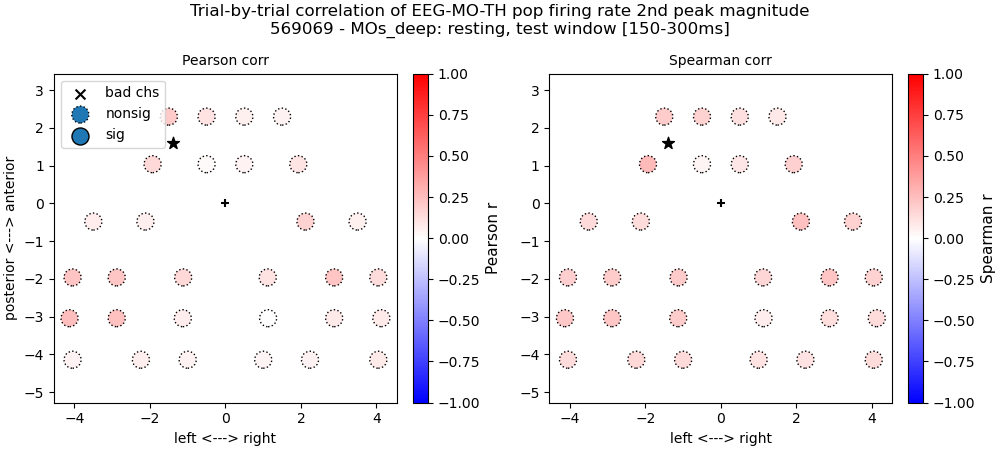

In [19]:
alpha = 0.01
fig, axs = plt.subplots(1, 2, figsize=(10,4.5), constrained_layout=True)
## Pearson ##
goodchmask = np.array([True if x in GOOD_CHS else False for x in range(eegtraces.shape[1])])
badchmask = ~goodchmask
sigmask = (Pps < alpha) * goodchmask
nonsigmask = (Pps >= alpha) * goodchmask
# plot bad chs #
axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][badchmask], EEGexp.EEG_channel_coordinates['AP'][badchmask],
    c='k', s=50, marker='x', label='bad chs'
)
# plot good chs, non significant #
axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][nonsigmask], EEGexp.EEG_channel_coordinates['AP'][nonsigmask],
    c=Prs[nonsigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', linestyle='dotted', label='nonsig'
)
# plot good chs, significant #
rcb = axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][sigmask], EEGexp.EEG_channel_coordinates['AP'][sigmask],
    c=Prs[sigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', label='sig'
)
axs[0].set_xlabel('left <---> right')
axs[0].set_ylabel('posterior <---> anterior')
axs[0].scatter(0, 0, marker='+', color='k')
axs[0].scatter(-1.4, 1.6, marker='*', color='k', s=80)
axs[0].axis('equal')
axs[0].legend(loc='upper left')
axs[0].set_title('Pearson corr')
cb = fig.colorbar(rcb, ax=axs[0], aspect=50)
cb.set_label('Pearson r', fontsize=11)

## Spearman ##
sigmask = (Spps < alpha) * goodchmask
nonsigmask = (Spps >= alpha) * goodchmask
# plot bad chs #
axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][badchmask], EEGexp.EEG_channel_coordinates['AP'][badchmask],
    c='k', s=50, marker='x', label='bad chs'
)
# plot good chs, non significant #
axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][nonsigmask], EEGexp.EEG_channel_coordinates['AP'][nonsigmask],
    c=Sprs[nonsigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', linestyle='dotted', label='nonsig'
)
# plot good chs, significant #
rcb = axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][sigmask], EEGexp.EEG_channel_coordinates['AP'][sigmask],
    c=Sprs[sigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', label='sig'
)
axs[1].set_xlabel('left <---> right')
axs[1].scatter(0, 0, marker='+', color='k')
axs[1].scatter(-1.4, 1.6, marker='*', color='k', s=80)
axs[1].axis('equal')
axs[1].set_title('Spearman corr')
cb = fig.colorbar(rcb, ax=axs[1], aspect=50)
cb.set_label('Spearman r', fontsize=11)

plt.suptitle(
    'Trial-by-trial correlation of EEG-{} pop firing rate 2nd peak magnitude\n{} - {}: {}, test window [{:d}-{:d}ms]'.format(
    regi, mouse_num, group, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3)
))

## Save ##
figname = 'corr_allEEGs2ndpeakto{}popFR_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    regi, mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## Population firing rates

<IPython.core.display.Javascript object>


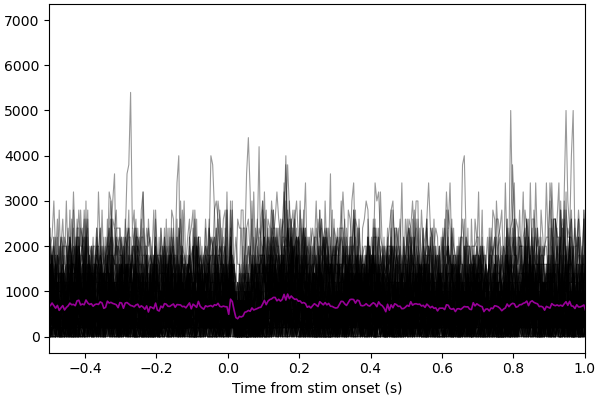

Text(0.5, 0, 'Time from stim onset (s)')

In [28]:
pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'

time_bin = 0.005
bins = np.arange(-2.0, 2.0 + time_bin, time_bin)
timex = bins[:-1] + time_bin / 2

popFRs = np.zeros((len(timex), len(all_event_inds[pstim][pstate])), dtype=float) * np.nan
for ei in range(len(all_event_inds[pstim][pstate])):
    spcounts, edges = np.histogram(pop_event_spikes[pstim][pstate][regi][ei], bins)
    popFRs[:, ei] = spcounts / time_bin
    
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.plot(timex, popFRs, color='k', linewidth=0.8, alpha=0.4)
ax.plot(timex, np.mean(popFRs, axis=1), color='m', linewidth=1.2, alpha=0.8)
ax.set_xlim([-0.5, 1.0])
ax.set_xlabel('Time from stim onset (s)')

<IPython.core.display.Javascript object>


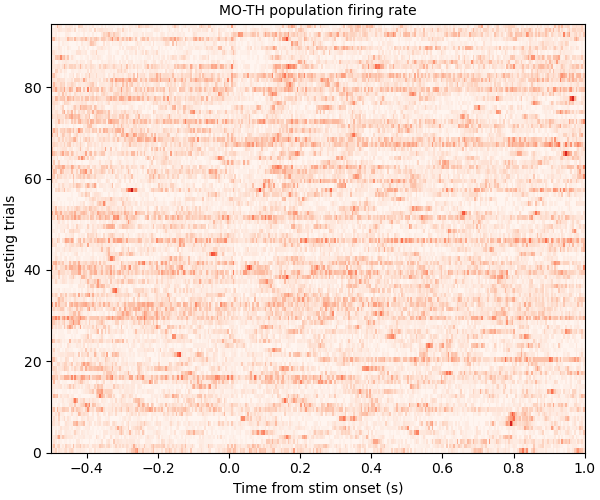

Text(0.5, 1.0, 'MO-TH population firing rate')

In [29]:
fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)
ax.imshow(
    popFRs.T, cmap='Reds', interpolation='none', aspect='auto', origin='upper',
    extent=[timex[0], timex[-1], 0, len(all_event_inds[pstim][pstate])]
)
# ax.plot(timex, popFRs, color='k', linewidth=0.8, alpha=0.4)
# ax.plot(timex, np.mean(popFRs, axis=1), color='m', linewidth=1.2, alpha=0.8)
ax.set_xlim([-0.5, 1.0])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('{} trials'.format(pstate))
ax.set_title('{} population firing rate'.format(regi))

In [24]:
test_window = [0.15, 0.25]

testinds = np.nonzero((timex >= test_window[0]) & (timex <= test_window[1]))[0]
blinds = np.nonzero((timex >= -test_window[1]) & (timex <= -test_window[0]))[0]

PKmag = np.zeros(popFRs.shape[1], dtype=float)
blmag = np.zeros(popFRs.shape[1], dtype=float)
for jj in range(popFRs.shape[1]):
    ## Get EEG metrics ##
    blmag[jj] = integrate.simps(popFRs[blinds, jj], timex[blinds], axis=0, even='last')
    PKmag[jj] = integrate.simps(popFRs[testinds, jj], timex[testinds], axis=0, even='last')
zPKmag = (PKmag - np.mean(blmag)) / np.std(blmag)

<IPython.core.display.Javascript object>


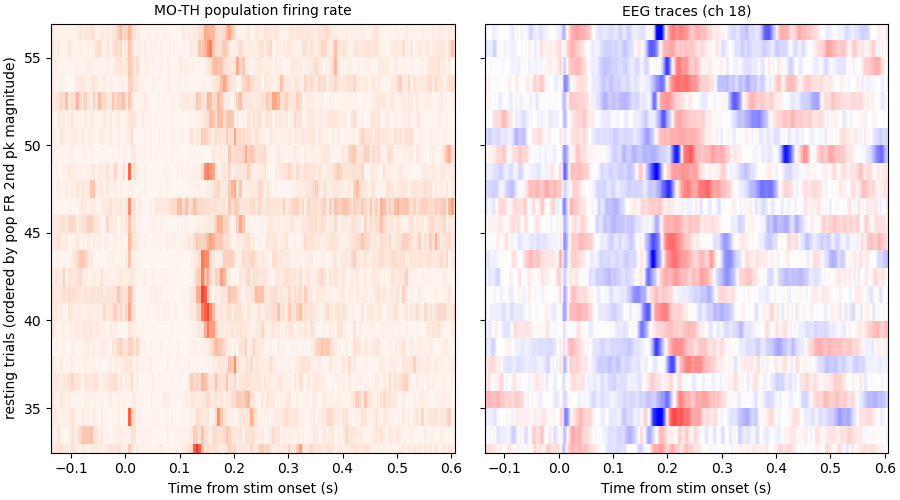

Text(0.5, 1.0, 'EEG traces (ch 18)')

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(9,5), sharex=True, sharey=True, constrained_layout=True)
## Plot pop firing rates ##
axs[0].imshow(
    popFRs.T[np.argsort(zPKmag)], cmap='Reds', interpolation='none', aspect='auto', origin='lower',
    extent=[timex[0], timex[-1], 0, len(all_event_inds[pstim][pstate])]
)
axs[0].set_xlim([-0.5, 1.0])
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_ylabel('{} trials (ordered by pop FR 2nd pk magnitude)'.format(pstate))
axs[0].set_title('{} population firing rate'.format(regi))

## Plot EEG traces ##
pch = 18
axs[1].imshow(
    EEG_traces[pstim][pstate][1][:, pch, :].T[np.argsort(zPKmag)], cmap='bwr', interpolation='none', aspect='auto',
    origin='lower', vmin=-400, vmax=400,
    extent=[EEG_traces[pstim][pstate][0][0], EEG_traces[pstim][pstate][0][-1], 0, len(all_event_inds[pstim][pstate])]
)
axs[1].set_xlabel('Time from stim onset (s)')
axs[1].set_title('EEG traces (ch {:d})'.format(pch))

<IPython.core.display.Javascript object>


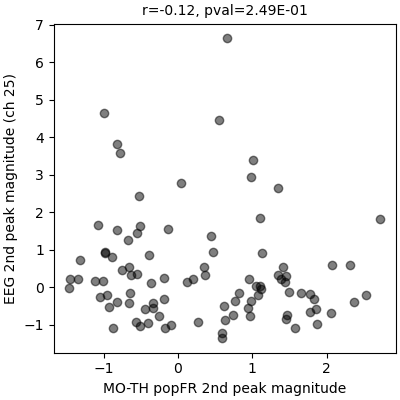

In [31]:
# test_window = [0.1, 0.4]
EEGch = 25

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1][:, EEGch, :]
einds = all_event_inds[pstim][pstate]

Etestinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
Eblinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]
FRtestinds = np.nonzero((timex >= test_window[0]) & (timex <= test_window[1]))[0]
FRblinds = np.nonzero((timex >= -test_window[1]) & (timex <= -test_window[0]))[0]

EEGmag = np.zeros(len(einds), dtype=float)
Eblmag = np.zeros(len(einds), dtype=float)
PKmag = np.zeros(popFRs.shape[1], dtype=float)
Pblmag = np.zeros(popFRs.shape[1], dtype=float)
for jj in range(len(einds)):
    ## Get EEG magnitude ##
    Eblmag[jj] = integrate.simps(np.abs(eegtraces[Eblinds, jj]), eegtime[Eblinds], axis=0, even='last')
    EEGmag[jj] = integrate.simps(np.abs(eegtraces[Etestinds, jj]), eegtime[Etestinds], axis=0, even='last')
    
    ## Get popFR magnitude ##
    Pblmag[jj] = integrate.simps(popFRs[FRblinds, jj], timex[FRblinds], axis=0, even='last')
    PKmag[jj] = integrate.simps(popFRs[FRtestinds, jj], timex[FRtestinds], axis=0, even='last')
    
emag = (EEGmag - np.mean(Eblmag)) / np.std(Eblmag)
zPKmag = (PKmag - np.mean(Pblmag)) / np.std(Pblmag)    

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.scatter(zPKmag, emag, c='k', alpha=0.5)
magres = stats.linregress(zPKmag, emag)
ax.set_xlabel('{} popFR 2nd peak magnitude'.format(regi))
ax.set_ylabel('EEG 2nd peak magnitude (ch {:d})'.format(EEGch))
ax.set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 50])

## Save ##
figname = 'corr_{:d}EEG2ndpeaktoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    EEGch, mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## Does EEG 2nd peak magnitude correlate with thalamic bursting on a trial-by-trial basis?

In [20]:
pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'
test_window = [0.1, 0.4]

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1]
einds = all_event_inds[pstim][pstate]

testinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
blinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

EEGmag = np.zeros((eegtraces.shape[1], len(einds)), dtype=float)
blmag = np.zeros((eegtraces.shape[1], len(einds)), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    blmag[:, jj] = integrate.simps(np.abs(eegtraces[blinds, :, jj]), eegtime[blinds], axis=0, even='last')
    EEGmag[:, jj] = integrate.simps(np.abs(eegtraces[testinds, :, jj]), eegtime[testinds], axis=0, even='last')
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / total_units
    
Prs, Pps = np.zeros((eegtraces.shape[1]), dtype=float), np.zeros((eegtraces.shape[1]), dtype=float)
Sprs, Spps = np.zeros((eegtraces.shape[1]), dtype=float), np.zeros((eegtraces.shape[1]), dtype=float)
for ii in range(eegtraces.shape[1]):
    Prs[ii], Pps[ii] = stats.pearsonr(pop_fraction, EEGmag[ii,:])
    Sprs[ii], Spps[ii] = stats.spearmanr(pop_fraction, EEGmag[ii,:])

<IPython.core.display.Javascript object>


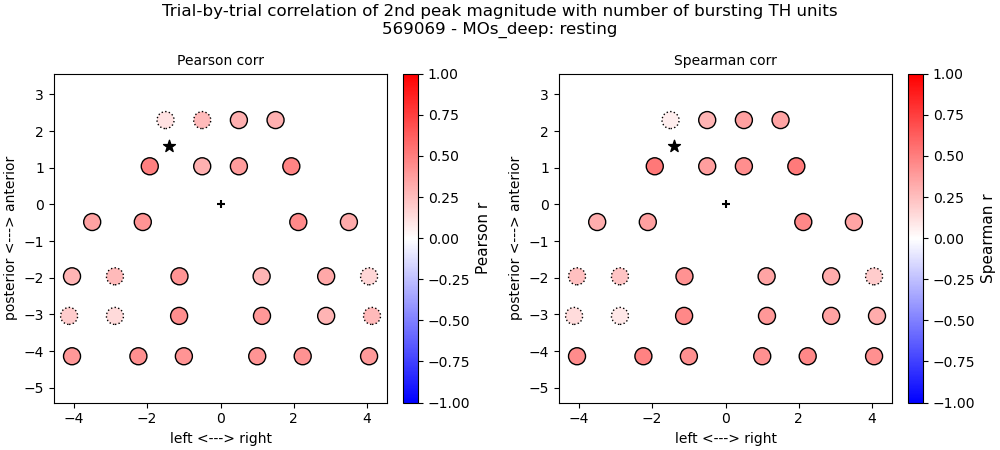

In [22]:
alpha = 0.01
fig, axs = plt.subplots(1, 2, figsize=(10,4.5), constrained_layout=True)
## Pearson ##
goodchmask = np.array([True if x in GOOD_CHS else False for x in range(eegtraces.shape[1])])
badchmask = ~goodchmask
sigmask = (Pps < alpha) * goodchmask
nonsigmask = (Pps >= alpha) * goodchmask
# plot bad chs #
axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][badchmask], EEGexp.EEG_channel_coordinates['AP'][badchmask],
    c='k', s=50, marker='x', label='bad chs'
)
# plot good chs, non significant #
axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][nonsigmask], EEGexp.EEG_channel_coordinates['AP'][nonsigmask],
    c=Prs[nonsigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', linestyle='dotted', label='nonsig'
)
# plot good chs, significant #
rcb = axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][sigmask], EEGexp.EEG_channel_coordinates['AP'][sigmask],
    c=Prs[sigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', label='sig'
)
axs[0].set_xlabel('left <---> right')
axs[0].set_ylabel('posterior <---> anterior')
axs[0].scatter(0, 0, marker='+', color='k')
axs[0].scatter(-1.4, 1.6, marker='*', color='k', s=80)
axs[0].axis('equal')
# axs[0].legend(loc='upper left')
axs[0].set_title('Pearson corr')
cb = fig.colorbar(rcb, ax=axs[0], aspect=50)
cb.set_label('Pearson r', fontsize=11)

## Spearman ##
sigmask = (Spps < alpha) * goodchmask
nonsigmask = (Spps >= alpha) * goodchmask
# plot bad chs #
axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][badchmask], EEGexp.EEG_channel_coordinates['AP'][badchmask],
    c='k', s=50, marker='x', label='bad chs'
)
# plot good chs, non significant #
axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][nonsigmask], EEGexp.EEG_channel_coordinates['AP'][nonsigmask],
    c=Sprs[nonsigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', linestyle='dotted', label='nonsig'
)
# plot good chs, significant #
rcb = axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][sigmask], EEGexp.EEG_channel_coordinates['AP'][sigmask],
    c=Sprs[sigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', label='sig'
)
axs[1].set_xlabel('left <---> right')
axs[1].set_ylabel('posterior <---> anterior')
axs[1].scatter(0, 0, marker='+', color='k')
axs[1].scatter(-1.4, 1.6, marker='*', color='k', s=80)
axs[1].axis('equal')
axs[1].set_title('Spearman corr')
cb = fig.colorbar(rcb, ax=axs[1], aspect=50)
cb.set_label('Spearman r', fontsize=11)

plt.suptitle('Trial-by-trial correlation of 2nd peak magnitude with number of bursting TH units\n{} - {}: {}'.format(
    mouse_num, group, pstate
))

## Save ##
figname = 'corr_allEEGs2ndpeaktoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


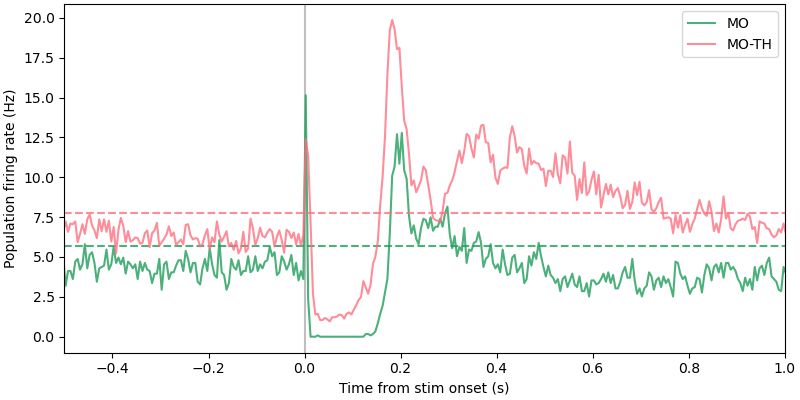

In [21]:
pstim = 'medium'
pstate = 'resting'
regis = {'MO': 'RS', 'MO-TH': None}

time_bin = 0.005
bins = np.arange(-2.0, 2.0 + time_bin, time_bin)
timex = bins[:-1] + time_bin / 2

pop_firing_rates = {}
for regi, cellty in regis.items():
    if cellty:
        unit_ids = reg_unit_info[regi]['unit_id'][reg_unit_info[regi]['cell_type'] == cellty].values
    else:
        unit_ids = reg_unit_info[regi]['unit_id'].values
    
    unit_firing_rates = np.zeros((len(unit_ids), len(timex)), dtype=float) * np.nan
    for indi, uid in enumerate(unit_ids):
        unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes[pstim][pstate][uid]), bins)
        unit_firing_rates[indi, :] = unit_event_counts / (time_bin * len(unit_event_spikes[pstim][pstate][uid]))
        
    pop_firing_rates[regi] = np.nanmean(unit_firing_rates, axis=0)
    
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.axvline(0, color='k', alpha=0.25)
for regi, popFR in pop_firing_rates.items():
    blmean = np.mean(popFR[timex < 0])
    blstd = np.std(popFR[timex < 0])
    ax.plot(timex, popFR, color=area_colors[regi], linewidth=1.5, alpha=0.8, label=regi)
    ax.axhline(blmean + (2 * blstd), color=area_colors[regi], linestyle='dashed', alpha=0.8)
ax.set_ylabel('Population firing rate (Hz)')
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim([-0.5, 1.0])
ax.legend()

### Investigating bursts

How many neurons burst on any one trial?

<IPython.core.display.Javascript object>


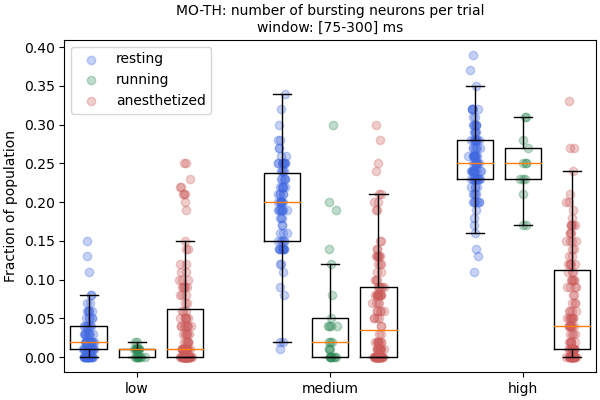

In [18]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
test_window = [0.075, 0.3]
regi = 'MO-TH'
total_units = len(reg_unit_info[regi])
barlocs = np.arange((len(state_colors) + 1) * len(current_levels)).reshape((len(current_levels), (len(state_colors) + 1)))

for aa, (leveli, states_event_times) in enumerate(all_event_inds.items()):
    scatlegend = []
    for bb, (statei, einds) in enumerate(states_event_times.items()):
        unit_counts = np.zeros(len(einds), dtype=int)
        for jj in range(len(einds)):
            uc = 0
            for ii, unitrow in reg_unit_info[regi].iterrows():
                uid = unitrow.unit_id
                uburstsi = np.array(unit_event_bursts[leveli][statei][uid]['times'][jj])
                counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    uc += 1
            unit_counts[jj] = uc
        
        ax.boxplot(unit_counts/total_units, positions=[barlocs[aa, bb]], widths=[0.75], showfliers=False)
        xs = np.random.normal(barlocs[aa, bb], 0.05, len(unit_counts))
        dots = ax.scatter(xs, unit_counts/total_units, c=state_colors[statei], alpha=0.3, label=statei)
        scatlegend.append(dots)
        
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(current_levels)
ax.set_ylabel('Fraction of population')
ax.set_title('{}: number of bursting neurons per trial\nwindow: [{}-{}] ms'.format(
    regi, int(test_window[0]*1E3), int(test_window[1]*1E3)))
ax.legend(handles=scatlegend)

## Save ##
figname = 'popfractionbursting_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

On how many trials do neurons burst?

<IPython.core.display.Javascript object>


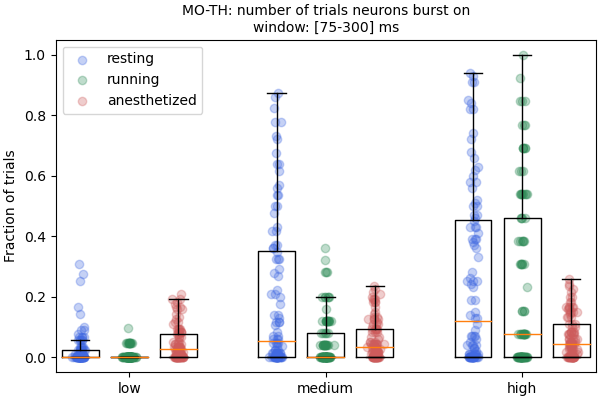

In [19]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
test_window = [0.075, 0.3]
regi = 'MO-TH'
total_units = len(reg_unit_info[regi])
barlocs = np.arange((len(state_colors) + 1) * len(current_levels)).reshape((len(current_levels), (len(state_colors) + 1)))

for aa, (leveli, states_event_times) in enumerate(all_event_inds.items()):
    scatlegend = []
    for bb, (statei, einds) in enumerate(states_event_times.items()):
        unit_counts = np.zeros(total_units, dtype=float)
        for ii, unitrow in reg_unit_info[regi].iterrows():
            uid = unitrow.unit_id
            trial_counts = np.zeros(len(einds), dtype=int)
            for jj in range(len(einds)):
                uburstsi = np.array(unit_event_bursts[leveli][statei][uid]['times'][jj])
                counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    trial_counts[jj] = 1
            unit_counts[ii] = np.mean(trial_counts)
        
        ax.boxplot(unit_counts, positions=[barlocs[aa, bb]], widths=[0.75], showfliers=False)#, showmeans=True)
        xs = np.random.normal(barlocs[aa, bb], 0.05, len(unit_counts))
        dots = ax.scatter(xs, unit_counts, c=state_colors[statei], alpha=0.3, label=statei)
        scatlegend.append(dots)
        
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(current_levels)
ax.set_ylabel('Fraction of trials')
ax.set_title('{}: number of trials neurons burst on\nwindow: [{}-{}] ms'.format(
    regi, int(test_window[0]*1E3), int(test_window[1]*1E3)))
ax.legend(handles=scatlegend)

## Save ##
figname = 'trialfractionbursting_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Burst PSTH for one neuron

<IPython.core.display.Javascript object>


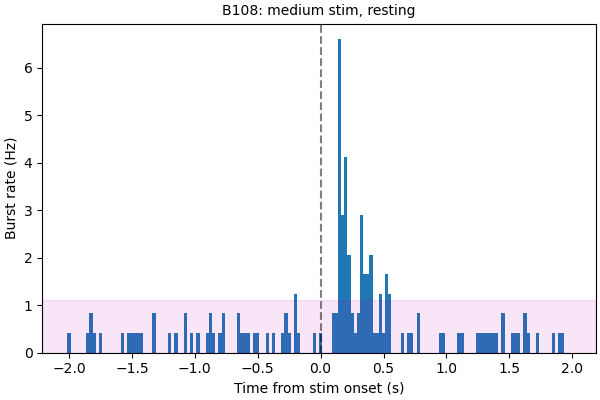

Text(0.5, 1.0, 'B108: medium stim, resting')

In [69]:
uid = 'B108'
pstim = 'medium'
pstate = 'resting'
tbin = 0.025
bins = np.arange(-2.0, 2.0 + tbin, tbin)

events = all_event_inds[pstim][pstate]
ubursts = unit_event_bursts[pstim][pstate][uid]['times']

burst_count, bedges = np.histogram(np.concatenate(ubursts), bins)
burst_rate = burst_count / (tbin * len(ubursts))
blmean = np.mean(burst_rate[bins[:-1] < 0])
blstd = np.std(burst_rate[bins[:-1] < 0])

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.bar(x=bins[:-1], height=burst_rate, width=tbin)
ax.axvline(0, color='k', linestyle='dashed', alpha=0.5)
ax.axhspan(0, blmean+(3*blstd), color='m', alpha=0.1)
ax.set_ylabel('Burst rate (Hz)')
ax.set_xlabel('Time from stim onset (s)')
ax.set_title('{}: {} stim, {}'.format(uid, pstim, pstate))

In [70]:
precount = np.zeros(len(ubursts), dtype=int)
postcount = np.zeros(len(ubursts), dtype=int)
for ie, bursttimes in enumerate(ubursts):
    precount[ie] = np.sum(bursttimes < 0)
    postcount[ie] = np.sum(bursttimes > 0)

In [71]:
wstat, pval = stats.wilcoxon(x=postcount, y=precount, zero_method='zsplit')
bcount = np.mean(postcount) - np.mean(precount)

In [72]:
print(pval)
print(bcount)

2.421650030154402e-07
0.6597938144329897


Trial-by-trial comparison of ERP magnitude/duration and fraction of TH pop with burst

<IPython.core.display.Javascript object>


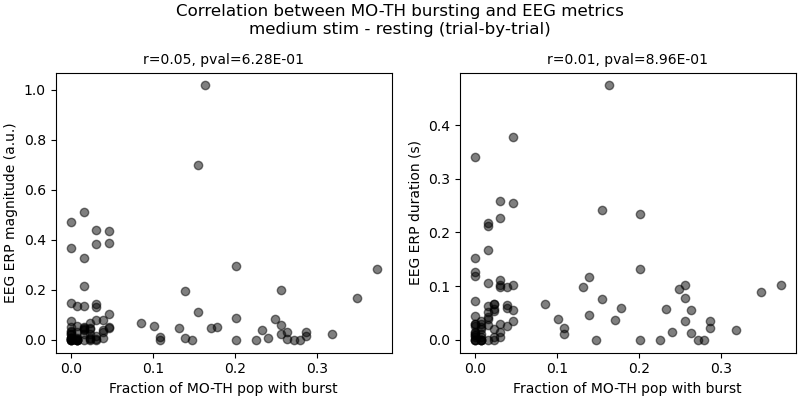

In [38]:
pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'
test_window = [0.15, 0.3]
zlim = 3

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1][:, mdata['good_chs'], :]
einds = all_event_inds[pstim][pstate]

EEGmag = np.zeros(len(einds), dtype=float)
EEGdur = np.zeros(len(einds), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    gfpow = np.std(eegtraces[:, :, jj], axis=1)
    zgfpow = (gfpow - np.mean(gfpow[eegtime < 0])) / np.std(gfpow[eegtime < 0])
    EEGdur[jj] = np.sum(zgfpow[eegtime > 0] > zlim) / mdata['exp'].ephys_params['EEG']['sample_rate']
    zerp = np.where((zgfpow[eegtime > 0] - zlim) >= 0, (zgfpow[eegtime > 0] - zlim), 0.)
    EEGmag[jj] = integrate.simps(zerp, eegtime[eegtime > 0], axis=0, even='last')
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / total_units
    
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, constrained_layout=True)
## EEG magnitude ##
axs[0].scatter(pop_fraction, EEGmag, c='k', alpha=0.5)
magres = stats.linregress(pop_fraction, EEGmag)
axs[0].set_xlabel('Fraction of {} pop with burst'.format(regi))
axs[0].set_ylabel('EEG ERP magnitude (a.u.)')
axs[0].set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))

## EEG duration ##
axs[1].scatter(pop_fraction, EEGdur, c='k', alpha=0.5)
durres = stats.linregress(pop_fraction, EEGdur)
axs[1].set_xlabel('Fraction of {} pop with burst'.format(regi))
axs[1].set_ylabel('EEG ERP duration (s)')
axs[1].set_title('r={:.2f}, pval={:.2E}'.format(durres.rvalue, durres.pvalue))

plt.suptitle('Correlation between {} bursting and EEG metrics\n{} stim - {} (trial-by-trial)'.format(regi, pstim, pstate))

## Save ##
figname = 'corr_EEGtoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## All subjects

In [15]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
time_bin = 0.005 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [16]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS

        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
                else:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][statei] = np.concatenate(state_events)

        ## Loop through regions to get units: RS only for CTX, all units for MO-TH ##
        reg_unit_info = {}
        for region in [stim_area, 'MO-TH']:
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            if len(regdf) > 8:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        if len(reg_unit_info) == 0:
            print('  Not enough units in cortex or thalamus; not analyzing this subject.')
            continue
        
        start = time.time()
        EEG_traces = {}
        pop_firing_rate = {}
        unit_event_bursts = {}
        for leveli, states_event_times in all_event_inds.items():
            EEG_traces[leveli] = {}
            pop_firing_rate[leveli] = {}
            unit_event_bursts[leveli] = {}
            for statei, event_inds in states_event_times.items():
                pop_firing_rate[leveli][statei] = {}
                unit_event_bursts[leveli][statei] = {}
                
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, event_inds]
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]
                
                for regi, regdf in reg_unit_info.items():
                    ## Get population event spike times ##
                    popFRs = np.zeros((len(timex), len(event_inds)), dtype=float) * np.nan
                    for ei, eventi in enumerate(event_inds):
                        event_spikes = []
                        for ii, unitrow in regdf.iterrows():
                            event_spikes.append(all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi])
                        spcounts, edges = np.histogram(np.sort(np.concatenate(event_spikes)), bins)
                        popFRs[:, ei] = spcounts / time_bin
                    pop_firing_rate[leveli][statei][regi] = [timex, popFRs]

                    ## Get unit event burst times ##
                    for ii, unitrow in regdf.iterrows():
                        unit_event_bursts[leveli][statei][unitrow.unit_id] = [
                            all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds
                        ]
                    
        mdata['EEG'] = EEG_traces
        mdata['popFR'] = pop_firing_rate
        mdata['unit_info'] = reg_unit_info
        mdata['bursts'] = unit_event_bursts
        
        del EEG_traces, pop_firing_rate, reg_unit_info, unit_event_bursts
        del unit_info, all_unit_event_spikes, all_EEG_traces, EEG_event_timestamps
        end = time.time()
        print('  Time to get event spike times: {:.2f} s'.format(end-start))
    print('')

MOs_superficial

 575102
  Time to get event spike times: 13.15 s
 571619
  Time to get event spike times: 25.08 s

MOs_deep

 546655
  Time to get event spike times: 14.17 s
 551399
  Time to get event spike times: 27.16 s
 551397
  Time to get event spike times: 30.37 s
 569062
  Time to get event spike times: 37.09 s
 569068
  Time to get event spike times: 21.09 s
 569069
  Time to get event spike times: 20.56 s
 569064
  Time to get event spike times: 14.84 s
 569073
  Time to get event spike times: 24.36 s
 571619
  Time to get event spike times: 27.69 s

SSp_superficial

 571620
  Time to get event spike times: 23.29 s
 586466
  Time to get event spike times: 13.34 s
 590479
  Time to get event spike times: 18.88 s
 590480
  Time to get event spike times: 25.31 s
 599017
  Not enough units in cortex or thalamus; not analyzing this subject.

SSp_deep

 569073
  Time to get event spike times: 22.20 s
 569072
  Time to get event spike times: 30.87 s
 571620
  Time to get event spik

### Get EEG and firing metrics

In [17]:
bug = [
    ['a', 'x', 10, np.array([0,1,2])],
    ['b', 'y', 20, np.array([3,4,5])],
    ['c', 'z', 30, np.array([1,3,5])]
]

bugdf = pd.DataFrame(bug, columns=['first', 'last', 'age', 'pigs'])
bugdf.head()

,first,last,age,pigs
0,a,x,10,"[0, 1, 2]"
1,b,y,20,"[3, 4, 5]"
2,c,z,30,"[1, 3, 5]"


In [22]:
## Tests Pearson correlation only now ##
test_window = [0.15, 0.3]
alpha = 0.01

pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'

all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        if 'popFR' not in mdata.keys():
            print('  No region data.')
            continue
        if regi not in mdata['popFR'][pstim][pstate].keys():
            print('  No {} data.'.format(regi))
            continue
        
        # EEG #
        eegtime = mdata['EEG'][pstim][pstate][0]
        eegtraces = mdata['EEG'][pstim][pstate][1]
        eeginds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
        bleeginds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]
        
        # popFR #
        frtime = mdata['popFR'][pstim][pstate][regi][0]
        popFR = mdata['popFR'][pstim][pstate][regi][1]
        frinds = np.nonzero((frtime >= test_window[0]) & (frtime <= test_window[1]))[0]
        blfrinds = np.nonzero((frtime >= -test_window[1]) & (frtime <= -test_window[0]))[0]
        
        # units #
        reg_unit_info = mdata['unit_info'][regi]
        event_bursts = mdata['bursts'][pstim][pstate]
        
        EEGauc = np.zeros((eegtraces.shape[1], eegtraces.shape[2]), dtype=float)
        blEEGauc = np.zeros((eegtraces.shape[1], eegtraces.shape[2]), dtype=float)
        FRauc = np.zeros(eegtraces.shape[2], dtype=float)
        blFRauc = np.zeros(eegtraces.shape[2], dtype=float)
        pop_fraction = np.zeros(eegtraces.shape[2], dtype=float)
        for jj in range(eegtraces.shape[2]):
            ## Get EEG metrics ##
            blEEGauc[:, jj] = integrate.simps(np.abs(eegtraces[bleeginds, :, jj]), eegtime[bleeginds], axis=0, even='last')
            EEGauc[:, jj] = integrate.simps(np.abs(eegtraces[eeginds, :, jj]), eegtime[eeginds], axis=0, even='last')
            
            ## Get popFR magnitude ##
            blFRauc[jj] = integrate.simps(popFR[blfrinds, jj], frtime[blfrinds], axis=0, even='last')
            FRauc[jj] = integrate.simps(popFR[frinds, jj], frtime[frinds], axis=0, even='last')
            
            ## Get pop fraction ##
            uc = 0
            for ui, unitrow in reg_unit_info.iterrows():
                uid = unitrow.unit_id
                uburstsi = np.array(event_bursts[uid][jj])
                counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    uc += 1
            pop_fraction[jj] = uc / len(reg_unit_info)
            
        EEGmag = (EEGauc - np.mean(blEEGauc, axis=0)) / np.std(blEEGauc, axis=0)
        FRmag = (FRauc - np.mean(blFRauc)) / np.std(blFRauc)
        
        popfr_rs, popfr_ps = np.zeros((eegtraces.shape[1]), dtype=float)*np.nan, np.ones((eegtraces.shape[1]), dtype=float)
        burst_rs, burst_ps = np.zeros((eegtraces.shape[1]), dtype=float)*np.nan, np.ones((eegtraces.shape[1]), dtype=float)
        for chi in mdata['good_chs']:
            popfr_rs[chi], popfr_ps[chi] = stats.pearsonr(FRmag, EEGmag[chi,:])
            burst_rs[chi], burst_ps[chi] = stats.pearsonr(pop_fraction, EEGmag[chi,:])
        
        all_subs_stats.append([
            group, mouse_num, stim_area, stim_depth, len(mdata['good_chs']), len(reg_unit_info),
            popfr_rs, popfr_ps, burst_rs, burst_ps
        ])
    print('')
## Create stats dataframe ##
all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'num_chs', 'num_units', 'popfr_R', 'popfr_P', 'burst_R', 'burst_P'
])

MOs_superficial
 575102
  No MO-TH data.
 571619

MOs_deep
 546655
 551399
 551397
 569062
 569068
 569069
 569064
  No MO-TH data.
 569073
 571619

SSp_superficial
 571620
 586466
  No MO-TH data.
 590479
  No MO-TH data.
 590480
 599017

SSp_deep
 569073
 569072
 571620
 586466
  No MO-TH data.
 590479
  No MO-TH data.
 590480
 599017



In [23]:
all_subs_stats_df.head()

,group,mouse,stim_area,stim_depth,num_chs,num_units,popfr_R,popfr_P,burst_R,burst_P
0,MOs_superficial,571619,MO,superficial,25,62,"[0.009122459267935121, -0.013237058213802999, ...","[0.9323836229395478, 0.9020135114303938, 1.0, ...","[0.21154098247002256, 0.2353813445885692, nan,...","[0.04658607091893682, 0.026385529331339294, 1...."
1,MOs_deep,546655,MO,deep,22,30,"[-0.34582093635669814, -0.3899454708073318, -0...","[0.028834385042978295, 0.012869050382778222, 0...","[0.09499163583189835, 0.03216862694213613, 0.0...","[0.559859561766404, 0.8437871092166725, 0.9533..."
2,MOs_deep,551399,MO,deep,22,82,"[nan, nan, -0.28935601814236944, nan, nan, -0....","[1.0, 1.0, 0.0023867680558379515, 1.0, 1.0, 0....","[nan, nan, 0.48074527702655856, nan, nan, 0.46...","[1.0, 1.0, 1.394690725083745e-07, 1.0, 1.0, 4...."
3,MOs_deep,551397,MO,deep,27,120,"[-0.09531290739405028, 0.13580041623380731, 0....","[0.35561964378318295, 0.1870829532136127, 0.24...","[0.23504392676580635, 0.546840466010214, 0.542...","[0.02115659741791064, 8.204782837186143e-09, 1..."
4,MOs_deep,569062,MO,deep,28,155,"[0.4365747341996776, 0.4339518302018104, 0.375...","[4.492560665230757e-06, 5.200607134994212e-06,...","[0.5592222454362629, 0.5695064260253649, 0.531...","[1.0017184827061817e-09, 4.2012560968979053e-1..."


### Plot correlation matrix side by side

<IPython.core.display.Javascript object>


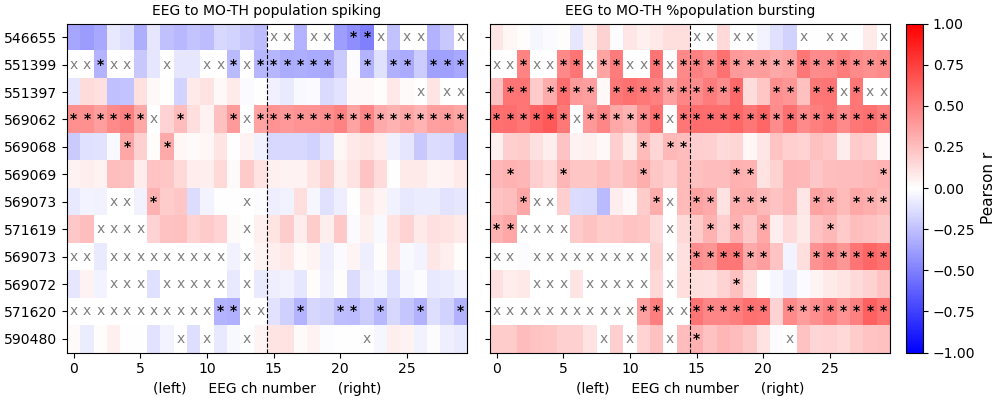

In [52]:
stim_depth = 'deep'

plotdf = all_subs_stats_df[all_subs_stats_df['stim_depth'] == stim_depth]
rvals = [np.stack(plotdf['popfr_R'].values), np.stack(plotdf['burst_R'].values)]
pvals = [np.stack(plotdf['popfr_P'].values), np.stack(plotdf['burst_P'].values)]

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True, constrained_layout=True)

for ax, rval, pval in zip(axs, rvals, pvals):
    Rcb = ax.imshow(rval, cmap='bwr', interpolation='none', aspect='auto', vmin=-1, vmax=1)
    ax.axvline(14.5, color='k', linewidth=0.8, linestyle='dashed')
    for ii in range(rval.shape[0]):
        for jj in range(rval.shape[1]):
            if np.isnan(rval[ii,jj]):
                ax.text(jj, ii, 'x', ha='center', va='center', color='gray')
            if pval[ii,jj] < alpha:
                ax.text(jj, ii, '*', ha='center', va='center', color='k', fontweight='bold')
    ax.set_xlabel('(left)     EEG ch number     (right)')

axs[0].set_yticks(np.arange(rval.shape[0]))
axs[0].set_yticklabels(plotdf['mouse'].values)
axs[0].set_title('EEG to {} population spiking'.format(regi))
axs[1].set_title('EEG to {} %population bursting'.format(regi))

cb = fig.colorbar(Rcb, ax=axs[1], aspect=50)
cb.set_label('Pearson r', fontsize=11)

## Save ##
figname = 'corr_allEEGstoTHactivity_{}stim_{}-{}_{:d}-{:d}ms.png'.format(
    stim_depth, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Make a plot comparing fraction responsive for stim ctx and MO-TH in superficial vs. deep stim 

<IPython.core.display.Javascript object>


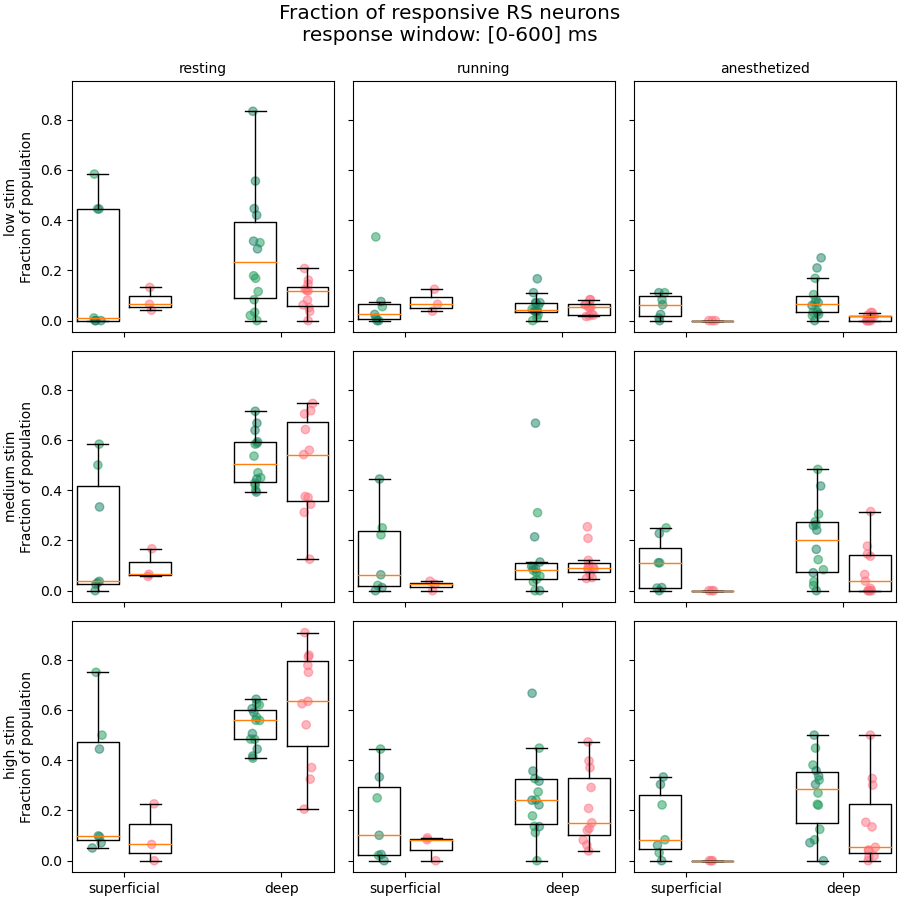

In [27]:
compare = ['superficial', 'deep']
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
barlocs = np.arange((len(plot_regions) + 1) * len(compare))
barlocs = barlocs.reshape((len(compare), (len(plot_regions) + 1)))

fig, axs = plt.subplots(
    len(current_levels), len(state_colors), figsize=(9, 9), sharex=True, sharey=True, constrained_layout=True)

for rowi, leveli in enumerate(current_levels):
    for coli, (statei, scolori) in enumerate(state_colors.items()):
        for ii, compi in enumerate(compare):
            for jj, (categ, spec) in enumerate(plot_regions.items()):
                df = all_subs_stats_df[
                    (all_subs_stats_df['stim_level'] == leveli) & (all_subs_stats_df['state'] == statei) &
                    (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
                ]
                fractions = df['fr_resp'].values
                sccolors = [area_colors[regi] for regi in df['region'].values]
                axs[rowi, coli].boxplot(fractions, positions=[barlocs[ii, jj]], widths=[0.8], showfliers=False)
                xs = np.random.normal(barlocs[ii, jj], 0.05, len(fractions))
                axs[rowi, coli].scatter(xs, fractions, c=sccolors, alpha=0.5)
                
#                 axs[rowi, coli].bar(barlocs[ii, jj], fraction, color=[area_colors[regi]])
        if rowi == 0:
            axs[rowi, coli].set_title(statei)
        if coli == 0:
            axs[rowi, coli].set_ylabel('{} stim\nFraction of population'.format(leveli))
axs[2,1].set_xticks(np.mean(barlocs[:,:-1], axis=1))
axs[2,1].set_xticklabels(compare)

## Make a legend ##
# mhandles = []
# for regi in plot_regions:
#     mhandles.append(Patch(color=area_colors[regi], label=regi))
# axs[0,0].legend(handles=mhandles)

plt.suptitle('Fraction of responsive {} neurons\nresponse window: [{:d}-{:d}] ms'.format(
    celltype, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Save ##
figname = 'FractionResponsive_all_supvsdeep_{:d}-{:d}ms.png'.format(int(test_window[0]*1E3), int(test_window[1]*1E3))
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


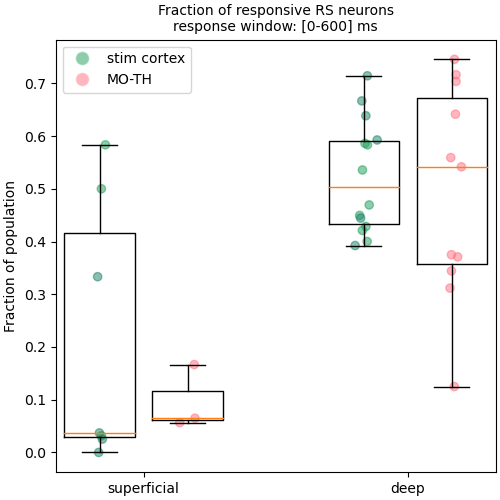

In [43]:
compare = ['superficial', 'deep']
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
barlocs = np.arange((len(plot_regions) + 1) * len(compare)).reshape((len(compare), (len(plot_regions) + 1)))

pstim = 'medium'
pstate = 'resting'

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

for ii, compi in enumerate(compare):
    for jj, (categ, spec) in enumerate(plot_regions.items()):
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_level'] == pstim) & (all_subs_stats_df['state'] == pstate) &
            (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
        ]
        fractions = df['fr_resp'].values
        sccolors = [area_colors[regi] for regi in df['region'].values]
        ax.boxplot(fractions, positions=[barlocs[ii, jj]], widths=[0.8], showfliers=False)
        xs = np.random.normal(barlocs[ii, jj], 0.05, len(fractions))
        ax.scatter(xs, fractions, c=sccolors, alpha=0.5)
ax.set_ylabel('Fraction of population')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(compare)

## Make a legend ##
mhandles = [
    Line2D([0], [0], marker='o', color='w', label='stim cortex', markerfacecolor=area_colors['MO'], markersize=10, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='MO-TH', markerfacecolor=area_colors['MO-TH'], markersize=10, alpha=0.5),
]

ax.legend(handles=mhandles)

ax.set_title('Fraction of responsive {} neurons\nresponse window: [{:d}-{:d}] ms'.format(
    celltype, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Save ##
figname = 'FractionResponsive_all_supvsdeep_{}-{}_{:d}-{:d}ms.png'.format(
    pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
fig.savefig(os.path.join(plotsdir, figname), transparent=False)